# DQN Agent

## Imports

In [1]:
# Evaluation tools
import random
import time

# RL Environment
import gym

# Vector tools
import numpy as np
import pandas as pd
from collections import deque

# ANN library
from keras import Sequential
from keras.layers import Dense
from keras.activations import relu, linear
from tensorflow.keras.optimizers import Adam
from keras.losses import mean_squared_error
from keras.models import load_model

# Model Serialization
import pickle
import dill

# Visualization library
from matplotlib import pyplot as plt

# Time elapsed
import time

In [2]:
start = time.time()

In [3]:
# import tensorflow as tf
# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True
# sess = tf.Session(config=config)

## Model

In [4]:
class DQN:
    def __init__(self, env, lr, gamma, epsilon, epsilon_decay):

        # Env setup
        self.env = env
        self.action_space = env.action_space
        self.observation_space = env.observation_space

        # Hyper params
        self.lr = lr
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.batch_ll_size = 64
        self.epsilon_ll_min = 0.01

        # Tracking progress
        self.rewards_ll_list = []
        self.avg_rewards_ll_list = []
        self.counter_ll = 0

        # Replay buffer
        self.replay_ll_memory_buffer = deque(maxlen=500000)
        
        # Model initialization 
        self.model = self.initialize_ll_model()

    def initialize_ll_model(self):
        
        # Define the model
        model = Sequential()
        model.add(Dense(512, input_dim=self.observation_space.shape[0], activation=relu))
        model.add(Dense(256, activation=relu))
        model.add(Dense(self.action_space.n, activation=linear))

        # Compile the model
        model.compile(loss=mean_squared_error,optimizer=Adam(learning_rate=self.lr))
        return model
    
    def model_summary(self):
        print(model.summary())

    def get_ll_action(self, state):
        if np.random.rand() < self.epsilon:
            return random.randrange(self.action_space.n)

        predicted_ll_actions = self.model.predict(state)
        return np.argmax(predicted_ll_actions[0])

    def add_to_ll_replay_memory(self, state, action, reward, next_state, done):
        self.replay_ll_memory_buffer.append((state, action, reward, next_state, done))

    def learn_and_update_ll_weights_by_reply(self):

        # replay_ll_memory_buffer size check
        if len(self.replay_ll_memory_buffer) < self.batch_ll_size or self.counter_ll != 0:
            return

        # Early Stopping
        if np.mean(self.rewards_ll_list[-10:]) > 180:
            return

        random_sample = self.get_random_sample_ll_from_replay_mem()
        states, actions, rewards, next_states, done_list = self.get_attribues_ll_from_sample(random_sample)
        targets = rewards + self.gamma * (np.amax(self.model.predict_on_batch(next_states), axis=1)) * (1 - done_list)
        target_vec = self.model.predict_on_batch(states)
        indexes = np.array([i for i in range(self.batch_ll_size)])
        target_vec[[indexes], [actions]] = targets

        self.model.fit(states, target_vec, epochs=1, verbose=0)

    def get_attribues_ll_from_sample(self, random_sample):
        states = np.array([i[0] for i in random_sample])
        actions = np.array([i[1] for i in random_sample])
        rewards = np.array([i[2] for i in random_sample])
        next_states = np.array([i[3] for i in random_sample])
        done_list = np.array([i[4] for i in random_sample])
        states = np.squeeze(states)
        next_states = np.squeeze(next_states)
        return np.squeeze(states), actions, rewards, next_states, done_list

    def get_random_sample_ll_from_replay_mem(self):
        random_sample = random.sample(self.replay_ll_memory_buffer, self.batch_ll_size)
        return random_sample

    def train(self, num_episodes=1000, can_stop=True):
                
        for episode in range(num_episodes):
            # Reset the lander
            state = env.reset()
            
            # Initialize the total episodic rewards to 0
            reward_for_ll_episode = 0
            
            # Limit the lander to making to 1000 steps
            num_steps = 1000
            
            # Transform the state
            state = np.reshape(state, [1, self.observation_space.shape[0]])
            
            # Iterate and take action in the environment
            for step in range(num_steps):
                
                # Get an action
                received_action = self.get_ll_action(state)

                # Take action in env
                next_state, reward, done, info = env.step(received_action)
                
                # Add the reward to the running count
                reward_for_ll_episode += reward
                
                # Transform the next state
                next_state = np.reshape(next_state, [1, self.observation_space.shape[0]])
                
                # Store the experience in replay memory
                self.add_to_ll_replay_memory(state, received_action, reward, next_state, done)
                
                # Set the next state
                state = next_state
                
                # Update the count
                self.update_ll_counter()
                
                # Execute experience replay
                self.learn_and_update_ll_weights_by_reply()

                # If the lander is in a terminal state, then stop taking steps
                if done:
                    break
                                
            
            # Decay the epsilon after each experience completion
            if self.epsilon > self.epsilon_ll_min:
                self.epsilon *= self.epsilon_decay
        
            # Add the total rewards to the tracker
            self.rewards_ll_list.append(reward_for_ll_episode)

            # Calcuate the running average rewards 
            last_rewards_mean = np.mean(self.rewards_ll_list[-100:])
            
            # Update the running average rewards
            self.avg_rewards_ll_list.append(last_rewards_mean)

#             # Determine stop condition
#             ## If the last 100 episodes have averaged total rewards over 200
#             if last_rewards_mean > 200 and can_stop:
#                 print("DQN Training Complete...")
#                 break
            
            
            print(episode, "\t: # of Episode || Reward: ",reward_for_ll_episode, "\t|| Average Reward = ",last_rewards_mean, "\t epsilon = ", self.epsilon )

    def update_ll_counter(self):
        self.counter_ll += 1
        step_size = 5
        self.counter_ll = self.counter_ll % step_size

    def save(self, name):
        self.model.save(name)

## Training

### Training Configuration

In [5]:
# Create the environment
env = gym.make('LunarLander-v2')
start = time.time()

# set seeds
env.seed(21)
env.reset()
np.random.seed(21)

# setting up hyperparams
lr = 0.001
epsilon = 1.0
epsilon_decay = 0.995
gamma = 0.99
training_episodes = 1000

### Training

In [6]:
# Initialize the model
model = DQN(env, lr, gamma, epsilon, epsilon_decay)

# Begin training
model.train(training_episodes, True)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


C:\Users\JoeyRagheb\anaconda3\envs\tensorflow2\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\JoeyRagheb\anaconda3\envs\tensorflow2\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
0 	: # of Episode || Reward:  -98.84021880850236 	|| Average Reward =  -98.84021880850236 	 epsilon =  0.995
1 	: # of Episode || Reward:  -149.5609885507592 	|| Average Reward =  -124.20060367963077 	 epsilon =  0.990025
2 	: # of Episode || Reward:  -340.0328037837126 	|| Average Reward =  -196.1446703809914 	 epsilon =  0.985074875
3 	: # of Episode || Reward:  -45.07596095958461 	|| Average Reward =  -158.3774930256397 	 epsilon =  0.9801495006250001
4 	: # of Episode || Reward:  -356.58281357763826 	|| Average Reward =  -198.01855713603942 	 epsilon =  0.9752487531218751
5 	: # of Episode || Reward:  -306.61717986957433 	|| Average Reward =  -216.11832759162857 	 epsilon =  0

63 	: # of Episode || Reward:  -105.56130129342544 	|| Average Reward =  -140.62923367974645 	 epsilon =  0.7255664080186093
64 	: # of Episode || Reward:  -82.15309540604193 	|| Average Reward =  -139.7296007832279 	 epsilon =  0.7219385759785162
65 	: # of Episode || Reward:  -109.88764800712269 	|| Average Reward =  -139.27744998358997 	 epsilon =  0.7183288830986236
66 	: # of Episode || Reward:  -99.75675349502413 	|| Average Reward =  -138.68758884196959 	 epsilon =  0.7147372386831305
67 	: # of Episode || Reward:  -108.50796532304643 	|| Average Reward =  -138.24377084904424 	 epsilon =  0.7111635524897149
68 	: # of Episode || Reward:  -115.10289117250892 	|| Average Reward =  -137.90839578126838 	 epsilon =  0.7076077347272662
69 	: # of Episode || Reward:  -85.57875434060871 	|| Average Reward =  -137.16082947497324 	 epsilon =  0.7040696960536299
70 	: # of Episode || Reward:  -65.01304586968985 	|| Average Reward =  -136.14466350870165 	 epsilon =  0.7005493475733617
71 	:

129 	: # of Episode || Reward:  -83.30829908456022 	|| Average Reward =  -86.25510109512378 	 epsilon =  0.5211953074858876
130 	: # of Episode || Reward:  -63.55388817356776 	|| Average Reward =  -82.56832114479158 	 epsilon =  0.5185893309484582
131 	: # of Episode || Reward:  -28.534621573853883 	|| Average Reward =  -81.90853180459861 	 epsilon =  0.5159963842937159
132 	: # of Episode || Reward:  -92.90876244543762 	|| Average Reward =  -81.98005503181575 	 epsilon =  0.5134164023722473
133 	: # of Episode || Reward:  -148.10482587167724 	|| Average Reward =  -82.55267444886749 	 epsilon =  0.510849320360386
134 	: # of Episode || Reward:  -130.20155313478884 	|| Average Reward =  -82.35769175216947 	 epsilon =  0.5082950737585841
135 	: # of Episode || Reward:  -71.44690549017467 	|| Average Reward =  -82.82832087201474 	 epsilon =  0.5057535983897912
136 	: # of Episode || Reward:  -89.36802131663174 	|| Average Reward =  -82.5047773282891 	 epsilon =  0.5032248303978422
137 	: 

195 	: # of Episode || Reward:  -9.961486401120737 	|| Average Reward =  -77.62427966961411 	 epsilon =  0.3743896431025813
196 	: # of Episode || Reward:  -68.53241652058972 	|| Average Reward =  -78.48343311497565 	 epsilon =  0.37251769488706843
197 	: # of Episode || Reward:  -90.46901244577052 	|| Average Reward =  -79.32802545288692 	 epsilon =  0.3706551064126331
198 	: # of Episode || Reward:  -16.757052374718995 	|| Average Reward =  -78.6558721254049 	 epsilon =  0.36880183088056995
199 	: # of Episode || Reward:  23.550490756387546 	|| Average Reward =  -77.6605646414012 	 epsilon =  0.3669578217261671
200 	: # of Episode || Reward:  37.293438473579755 	|| Average Reward =  -77.3504475264085 	 epsilon =  0.36512303261753626
201 	: # of Episode || Reward:  -84.09641293392615 	|| Average Reward =  -78.72416222378993 	 epsilon =  0.3632974174544486
202 	: # of Episode || Reward:  -21.46247125309887 	|| Average Reward =  -78.12125455599578 	 epsilon =  0.3614809303671764
203 	: 

262 	: # of Episode || Reward:  26.703307137061987 	|| Average Reward =  -29.693570739291594 	 epsilon =  0.26759021970270175
263 	: # of Episode || Reward:  28.96719291890048 	|| Average Reward =  -29.550255034845474 	 epsilon =  0.2662522686041882
264 	: # of Episode || Reward:  0.3567179423755773 	|| Average Reward =  -29.28586302209907 	 epsilon =  0.2649210072611673
265 	: # of Episode || Reward:  89.47455964010692 	|| Average Reward =  -28.1372921247906 	 epsilon =  0.26359640222486147
266 	: # of Episode || Reward:  -153.08111642801023 	|| Average Reward =  -29.004228716069775 	 epsilon =  0.26227842021373715
267 	: # of Episode || Reward:  15.07168913129729 	|| Average Reward =  -27.05613035025442 	 epsilon =  0.2609670281126685
268 	: # of Episode || Reward:  61.55301835801646 	|| Average Reward =  -24.14536838450198 	 epsilon =  0.25966219297210513
269 	: # of Episode || Reward:  250.05771664418444 	|| Average Reward =  -21.012072534382206 	 epsilon =  0.2583638820072446
270 

328 	: # of Episode || Reward:  2.5889772278772645 	|| Average Reward =  35.33081605946459 	 epsilon =  0.192217783647157
329 	: # of Episode || Reward:  107.31428730455832 	|| Average Reward =  36.99629570922694 	 epsilon =  0.1912566947289212
330 	: # of Episode || Reward:  119.84297067778732 	|| Average Reward =  37.88692557566143 	 epsilon =  0.1903004112552766
331 	: # of Episode || Reward:  252.963837839265 	|| Average Reward =  40.2820373241165 	 epsilon =  0.18934890919900021
332 	: # of Episode || Reward:  135.27974018413917 	|| Average Reward =  41.10537264597454 	 epsilon =  0.18840216465300522
333 	: # of Episode || Reward:  143.56766668902904 	|| Average Reward =  42.43532004016509 	 epsilon =  0.18746015382974018
334 	: # of Episode || Reward:  264.75701046160697 	|| Average Reward =  45.28992746512577 	 epsilon =  0.1865228530605915
335 	: # of Episode || Reward:  226.06872878642363 	|| Average Reward =  48.22140892458267 	 epsilon =  0.18559023879528855
336 	: # of Epis

395 	: # of Episode || Reward:  203.41975970084115 	|| Average Reward =  94.49280993739839 	 epsilon =  0.13738520790976036
396 	: # of Episode || Reward:  142.2732494192011 	|| Average Reward =  95.32634850336143 	 epsilon =  0.13669828187021155
397 	: # of Episode || Reward:  175.55039225903846 	|| Average Reward =  95.69169071598414 	 epsilon =  0.13601479046086049
398 	: # of Episode || Reward:  82.07498108075643 	|| Average Reward =  96.85975169401583 	 epsilon =  0.1353347165085562
399 	: # of Episode || Reward:  -23.619232360242023 	|| Average Reward =  95.41294354985718 	 epsilon =  0.1346580429260134
400 	: # of Episode || Reward:  109.60771011088023 	|| Average Reward =  96.12364946630541 	 epsilon =  0.13398475271138335
401 	: # of Episode || Reward:  -19.989078065680285 	|| Average Reward =  95.11653621357853 	 epsilon =  0.13331482894782642
402 	: # of Episode || Reward:  247.5147757095714 	|| Average Reward =  99.83262460764743 	 epsilon =  0.13264825480308728
403 	: # of

462 	: # of Episode || Reward:  209.8094387113398 	|| Average Reward =  175.31431375344707 	 epsilon =  0.09819432413732986
463 	: # of Episode || Reward:  140.5995733431954 	|| Average Reward =  174.28717057053754 	 epsilon =  0.09770335251664321
464 	: # of Episode || Reward:  251.2277491946043 	|| Average Reward =  174.031890032884 	 epsilon =  0.09721483575406
465 	: # of Episode || Reward:  218.27475019153647 	|| Average Reward =  176.8051591811979 	 epsilon =  0.09672876157528969
466 	: # of Episode || Reward:  228.20990285308494 	|| Average Reward =  178.41280456355446 	 epsilon =  0.09624511776741324
467 	: # of Episode || Reward:  192.1491959742299 	|| Average Reward =  180.23802576962564 	 epsilon =  0.09576389217857617
468 	: # of Episode || Reward:  121.31646133095393 	|| Average Reward =  178.95003060418233 	 epsilon =  0.09528507271768329
469 	: # of Episode || Reward:  225.71662986378243 	|| Average Reward =  178.74272187184633 	 epsilon =  0.09480864735409487
470 	: # o

528 	: # of Episode || Reward:  -220.70794565649618 	|| Average Reward =  212.66114444988887 	 epsilon =  0.07053581918419231
529 	: # of Episode || Reward:  220.7680635674205 	|| Average Reward =  212.3162448478874 	 epsilon =  0.07018314008827135
530 	: # of Episode || Reward:  174.19716391566442 	|| Average Reward =  211.97819556608917 	 epsilon =  0.06983222438783
531 	: # of Episode || Reward:  227.9497200588322 	|| Average Reward =  211.5638889952697 	 epsilon =  0.06948306326589085
532 	: # of Episode || Reward:  285.03883401491925 	|| Average Reward =  212.09127394047343 	 epsilon =  0.0691356479495614
533 	: # of Episode || Reward:  233.7749880540262 	|| Average Reward =  211.97576542863646 	 epsilon =  0.06878996970981359
534 	: # of Episode || Reward:  -69.2792002603537 	|| Average Reward =  208.82200396848432 	 epsilon =  0.06844601986126451
535 	: # of Episode || Reward:  230.51666474851305 	|| Average Reward =  209.2544585622235 	 epsilon =  0.06810378976195819
536 	: # o

594 	: # of Episode || Reward:  -297.0104396517635 	|| Average Reward =  112.20134003036551 	 epsilon =  0.05066791621302729
595 	: # of Episode || Reward:  -24.66326907278419 	|| Average Reward =  110.53484119439257 	 epsilon =  0.05041457663196215
596 	: # of Episode || Reward:  -141.81368677872248 	|| Average Reward =  106.96031682187414 	 epsilon =  0.050162503748802344
597 	: # of Episode || Reward:  -72.84527299816614 	|| Average Reward =  104.08122342499746 	 epsilon =  0.049911691230058335
598 	: # of Episode || Reward:  -79.8033571565646 	|| Average Reward =  101.25724030088003 	 epsilon =  0.04966213277390804
599 	: # of Episode || Reward:  -85.46121100010913 	|| Average Reward =  98.45124470506227 	 epsilon =  0.0494138221100385
600 	: # of Episode || Reward:  -129.4161615733322 	|| Average Reward =  94.69529801866624 	 epsilon =  0.04916675299948831
601 	: # of Episode || Reward:  8.971237065659906 	|| Average Reward =  92.56883645722098 	 epsilon =  0.04892091923449087
602

661 	: # of Episode || Reward:  296.4864031743678 	|| Average Reward =  70.77483254694017 	 epsilon =  0.03621424652392737
662 	: # of Episode || Reward:  195.42550430286792 	|| Average Reward =  74.3908727466902 	 epsilon =  0.036033175291307735
663 	: # of Episode || Reward:  218.47849303431732 	|| Average Reward =  74.71877659337908 	 epsilon =  0.03585300941485119
664 	: # of Episode || Reward:  180.88151276724795 	|| Average Reward =  74.689500449927 	 epsilon =  0.035673744367776934
665 	: # of Episode || Reward:  185.53247796584967 	|| Average Reward =  78.56664027489744 	 epsilon =  0.03549537564593805
666 	: # of Episode || Reward:  229.7120631002914 	|| Average Reward =  80.99298670398251 	 epsilon =  0.035317898767708356
667 	: # of Episode || Reward:  255.69790282619064 	|| Average Reward =  82.29287708927978 	 epsilon =  0.03514130927386981
668 	: # of Episode || Reward:  188.21738763001358 	|| Average Reward =  81.9966312455383 	 epsilon =  0.03496560272750046
669 	: # of

727 	: # of Episode || Reward:  265.2324794899803 	|| Average Reward =  191.85830789434596 	 epsilon =  0.02601373925779093
728 	: # of Episode || Reward:  269.5044480076673 	|| Average Reward =  194.74307142711754 	 epsilon =  0.025883670561501974
729 	: # of Episode || Reward:  217.3651933945755 	|| Average Reward =  197.6342957582114 	 epsilon =  0.025754252208694463
730 	: # of Episode || Reward:  250.42782984928556 	|| Average Reward =  198.38891355086434 	 epsilon =  0.02562548094765099
731 	: # of Episode || Reward:  251.08840112022335 	|| Average Reward =  197.95361673059372 	 epsilon =  0.025497353542912736
732 	: # of Episode || Reward:  205.52702799078128 	|| Average Reward =  198.30875694483632 	 epsilon =  0.02536986677519817
733 	: # of Episode || Reward:  194.20302394342718 	|| Average Reward =  198.436167760189 	 epsilon =  0.02524301744132218
734 	: # of Episode || Reward:  218.92148868139998 	|| Average Reward =  201.09232091031095 	 epsilon =  0.025116802354115567
73

793 	: # of Episode || Reward:  249.93042021318527 	|| Average Reward =  227.88535939496774 	 epsilon =  0.018686420266267767
794 	: # of Episode || Reward:  214.6752714421188 	|| Average Reward =  228.01171359308552 	 epsilon =  0.018592988164936427
795 	: # of Episode || Reward:  263.24928215653244 	|| Average Reward =  228.23639882264092 	 epsilon =  0.018500023224111744
796 	: # of Episode || Reward:  140.8552953182849 	|| Average Reward =  227.35608581168634 	 epsilon =  0.018407523107991184
797 	: # of Episode || Reward:  177.75861379748565 	|| Average Reward =  226.56044881333727 	 epsilon =  0.01831548549245123
798 	: # of Episode || Reward:  244.92969436654693 	|| Average Reward =  227.0579163193011 	 epsilon =  0.018223908064988973
799 	: # of Episode || Reward:  265.19382630822923 	|| Average Reward =  227.5056232938975 	 epsilon =  0.018132788524664028
800 	: # of Episode || Reward:  160.57720758684633 	|| Average Reward =  226.54757322767497 	 epsilon =  0.0180421245820407

859 	: # of Episode || Reward:  174.69037919323932 	|| Average Reward =  224.6105197043308 	 epsilon =  0.013422995398979608
860 	: # of Episode || Reward:  238.68945387512875 	|| Average Reward =  225.225751420291 	 epsilon =  0.01335588042198471
861 	: # of Episode || Reward:  179.68125167581098 	|| Average Reward =  224.38972574763918 	 epsilon =  0.013289101019874787
862 	: # of Episode || Reward:  254.96418288938105 	|| Average Reward =  224.47179788969277 	 epsilon =  0.013222655514775413
863 	: # of Episode || Reward:  249.16392030662251 	|| Average Reward =  225.1022673054215 	 epsilon =  0.013156542237201536
864 	: # of Episode || Reward:  246.87121216943711 	|| Average Reward =  225.3552639583991 	 epsilon =  0.013090759526015528
865 	: # of Episode || Reward:  239.1633281025354 	|| Average Reward =  225.65693758518103 	 epsilon =  0.01302530572838545
866 	: # of Episode || Reward:  261.5351077952554 	|| Average Reward =  226.67287256431453 	 epsilon =  0.012960179199743523
8

925 	: # of Episode || Reward:  225.88040454435006 	|| Average Reward =  222.8846638816821 	 epsilon =  0.00998645168764533
926 	: # of Episode || Reward:  249.71253609053232 	|| Average Reward =  223.63972894273394 	 epsilon =  0.00998645168764533
927 	: # of Episode || Reward:  242.24870870143064 	|| Average Reward =  223.6531206849547 	 epsilon =  0.00998645168764533
928 	: # of Episode || Reward:  276.24623591617905 	|| Average Reward =  223.7944076775767 	 epsilon =  0.00998645168764533
929 	: # of Episode || Reward:  232.3526527881917 	|| Average Reward =  223.4970370441523 	 epsilon =  0.00998645168764533
930 	: # of Episode || Reward:  199.54721890260006 	|| Average Reward =  223.25386013916818 	 epsilon =  0.00998645168764533
931 	: # of Episode || Reward:  254.08895279811466 	|| Average Reward =  223.28839938370095 	 epsilon =  0.00998645168764533
932 	: # of Episode || Reward:  190.32680511556896 	|| Average Reward =  223.43962225087984 	 epsilon =  0.00998645168764533
933 	

991 	: # of Episode || Reward:  -272.3667124481427 	|| Average Reward =  219.45735700627588 	 epsilon =  0.00998645168764533
992 	: # of Episode || Reward:  168.81082564736477 	|| Average Reward =  219.5523257692487 	 epsilon =  0.00998645168764533
993 	: # of Episode || Reward:  97.58170410706019 	|| Average Reward =  218.5761814655258 	 epsilon =  0.00998645168764533
994 	: # of Episode || Reward:  233.73133462100225 	|| Average Reward =  218.4139895265831 	 epsilon =  0.00998645168764533
995 	: # of Episode || Reward:  272.83676994560176 	|| Average Reward =  219.56836424057477 	 epsilon =  0.00998645168764533
996 	: # of Episode || Reward:  277.31917454356994 	|| Average Reward =  219.91391792898364 	 epsilon =  0.00998645168764533
997 	: # of Episode || Reward:  222.09698765142906 	|| Average Reward =  219.3761733592428 	 epsilon =  0.00998645168764533
998 	: # of Episode || Reward:  -193.55626543015163 	|| Average Reward =  215.87465617212482 	 epsilon =  0.00998645168764533
999 

### Save the model

In [7]:
# Directory to dump the model data
save_dir = "./"

# Save trained model
model.save(save_dir + "trained_model.h5")

# Serialize the replay buffer
experiences = dill.dumps(model.replay_ll_memory_buffer)

# Save the replay buffer
pickle.dump(experiences, open(save_dir + "train_replay_buffer.p", "wb"))

# Save the average rewards and rewards
## Used later for comparison and evaluation
pickle.dump(model.rewards_ll_list, open(save_dir + "train_rewards_list.p", "wb"))
pickle.dump(model.avg_rewards_ll_list, open(save_dir + "train_rewards_avg_list.p", "wb"))

### Visualize Training

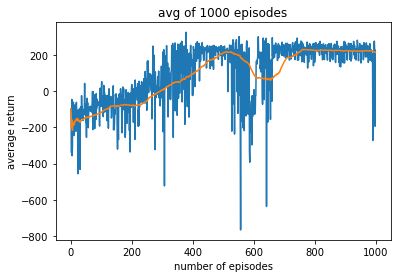

In [8]:
# First Figure
plt.figure("Rewards_means")
title = "avg of " + str(len(model.rewards_ll_list)) + " episodes"
plt.title(title)
plt.xlabel("number of episodes")
plt.ylabel("average return")
plt.plot(model.rewards_ll_list)
plt.plot(model.avg_rewards_ll_list)
plt.show()

### Time Elapsed

In [9]:
end_one = time.time()
print(str((end_one - start) / 60) + ' minutes')

322.913158873717 minutes


## Evaluation

### Define evaluation method for testing

In [10]:
def test_already_trained_ll_model(trained_model, render=False):
    
    rewards_ll_list = []
    avg_rewards_ll_list = []
    num_ll_test_episode = 20
    
    env = gym.make("LunarLander-v2")
    print("Starting to test the trained model:")

    step_count = 1000

    for test_ll_episode in range(num_ll_test_episode):
        current_state = env.reset()
        num_observation_space = env.observation_space.shape[0]
        current_state = np.reshape(current_state, [1, num_observation_space])
        reward_for_ll_episode = 0
        for step in range(step_count):
            
            if render:
                env.render()
                
            selected_action = np.argmax(trained_model.predict(current_state)[0])
            new_state, reward, done, info = env.step(selected_action)
            new_state = np.reshape(new_state, [1, num_observation_space])
            current_state = new_state
            reward_for_ll_episode += reward
            if done:
                break
        rewards_ll_list.append(reward_for_ll_episode)
        
        print(test_ll_episode, "\t: Episode || Reward: ", reward_for_ll_episode)
        
        env.close()

    return rewards_ll_list

### Evaluate

In [11]:
# Directory to load the model data
save_dir = "./"

# Load the model
trained_model = load_model(save_dir + "trained_model.h5")

# Load the replay buffer and assign it to the model
experiences = pickle.load(open(save_dir + "train_replay_buffer.p", "rb"))
trained_model.replay_ll_memory_buffer = dill.loads(experiences)

# Evaluate the model
test_rewards = test_already_trained_ll_model(trained_model)

# Save the results
pickle.dump(test_rewards, open(save_dir + "test_rewards.p", "wb"))

Starting to test the trained model:
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
0 	: Episode || Reward:  226.7822262346382
1 	: Episode || Reward:  62.070634661405094
2 	: Episode || Reward:  261.95047612540753
3 	: Episode || Reward:  72.34007059601804
4 	: Episode || Reward:  212.0086484518476
5 	: Episode || Reward:  227.05370437963646
6 	: Episode || Reward:  200.09063237543782
7 	: Episode || Reward:  199.77008151

### Evaluation Visual

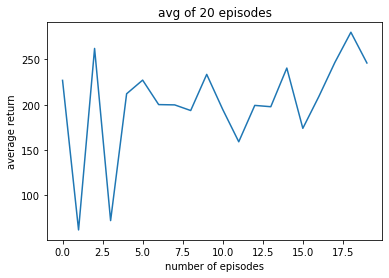

In [12]:
plt.figure("Rewards_means")
title = "avg of " + str(len(test_rewards)) + " episodes"
plt.title(title)
plt.xlabel("number of episodes")
plt.ylabel("average return")
plt.plot(test_rewards)
plt.show()

### Time elapsed

In [13]:
end_two = time.time()
print(str((end_two - start) / 60) + ' minutes')

329.1248694698016 minutes


## Visualization

In [14]:
# def plot_experiments(df, chart_name, title, x_axis_label, y_axis_label, y_limit):
#     plt.rcParams.update({'font.size': 17})
#     plt.figure(figsize=(15, 8))
#     plt.close()
#     plt.figure()
#     plot = df.plot(linewidth=1, figsize=(15, 8), title=title)
#     plot.set_xlabel(x_axis_label)
#     plot.set_ylabel(y_axis_label)
#     plt.ylim(y_limit)
#     fig = plot.get_figure()
#     fig.savefig(chart_name)

In [15]:
# list_of_episodes = [*range(0, training_episodes, 1)]
# print(".")
# plt.figure("Rewards_means")
# title = "avg of " + str(training_episodes) + " episodes"
# plt.title(title)
# plt.xlabel("number of episodes")
# plt.ylabel("average return")
# plt.plot(list_of_episodes, rewards_list_)
# plt.plot(list_of_episodes, aver_reward)
# plt.show()


# # Load the model the model
# trained_model = load_model(save_dir + "trained_model.h5")
# test_rewards = test_already_trained_ll_model(trained_model)
# pickle.dump(test_rewards, open(save_dir + "test_rewards.p", "wb"))
# test_rewards = pickle.load(open(save_dir + "test_rewards.p", "rb"))


# end = time.time()
# print(str((end - start) / 60) + ' minutes')
